In [1]:
from typing import List
import re
import string
import math
import os

import torch

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from itertools import chain

import gensim

import gc
import time
import random

/soe/vigneshs/miniconda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# select device
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=5)

In [3]:
seed = 1111

In [4]:
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
_numpy_rng = np.random.default_rng(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)


In [5]:
train_path = "/soe/vigneshs/projects/nlp_244/NLP244-quest1/data/wikitext-2-mini/wiki.train.tokens"
valid_path = "/soe/vigneshs/projects/nlp_244/NLP244-quest1/data/wikitext-2-mini/wiki.valid.tokens"
test_path = "/soe/vigneshs/projects/nlp_244/NLP244-quest1/data/wikitext-2-mini/wiki.test.tokens"

path_to_glove_embeddings_in_gensim_word2vec_format = "/soe/vigneshs/projects/nlp_244/NLP244-quest1/glove/glove-word2vec.6B.50d.txt"
best_model_path = '/soe/vigneshs/projects/nlp_243/3/models/5/model.pth'


In [6]:
gensim_glove_weights = gensim.models.KeyedVectors.load_word2vec_format(path_to_glove_embeddings_in_gensim_word2vec_format)

In [7]:
def get_sentences(path):
    with open(path, "r", encoding="utf8") as f:
        lines = f.readlines()
        sentences = [line for line in lines]
        return sentences

In [8]:
train_data = get_sentences(path=train_path)
valid_data = get_sentences(path=valid_path)
test_data = get_sentences(path=test_path)

In [9]:
# Class to tokenize and encode dataset
class Sequencer(object):
    def __init__(self, corpus, bos_token='<s>', eos_token='</s>', unk_token='<unk>', pad_token='<pad>'):
        self.word2idx = {}
        self.idx2word = {}
        
        # <unk> - unknown token
        self.unk_index = self.add_token(unk_token) 
        
        # <pad> - padding token
        self.pad_index = self.add_token(pad_token)

        # <s> - start of senetnce token
        self.bos_index = self.add_token(bos_token)

        # </s> - end of sentence token
        self.eos_index = self.add_token(eos_token)
        
        # Tokenization by splitting on spaces
        self.tokenizer = lambda text: [t for t in text.split(' ')]

        for _sentence in corpus:
            for _token in self.tokenizer(_sentence):
                self.add_token(_token)

    def add_token(self, token):
        """
        Function to add token. Adds it to both word2idx and idx2word
        """
        if token not in self.word2idx:
            self.word2idx[token] = new_index = len(self.word2idx)
            self.idx2word[new_index] = token
            return new_index
        else:
            return self.word2idx[token]

    def encode(self, text):
        """
        Function to encode text.
        We prepend the text by start of sentence token <s> and append an end of sentence token </s>.
        """
        tokens = self.tokenizer(text)

        sequence = []
        sequence.append(self.bos_index)

        for token in tokens:

            index = self.word2idx.get(token, self.unk_index)
            sequence.append(index)

        sequence.append(self.eos_index)
        return sequence

    def create_padded_tensor(self, sequences):
        """
        Funtion to pad a batch of sequences with pad token <pad>
        """
        
        lengths = [len(sequence) for sequence in sequences]
        max_seq_len = max(lengths)
        tensor = torch.full((len(sequences), max_seq_len), self.pad_index, dtype=torch.long)

        for i, sequence in enumerate(sequences):
            for j, token in enumerate(sequence):
                tensor[i][j] = token
        
        return tensor, torch.tensor(lengths)

In [10]:
# Class to tokenize and encode dataset using pre-trained embeddings
# This is to ensure that we don't use the complete pre-trained embeddings
# which can have a lot of tokens and increase the memory requirement.
# If we don't do this tt fails for higher batchsizes (64, 128) due cuda to memory issues.
class PreTrainedSequencer(object):
    def __init__(self, corpus, gensim_w2v, embedding_dim, bos_token='<s>', eos_token='</s>', unk_token='<unk>', pad_token='<pad>'):

        self.idx2word = {}
        self.word2idx = {}
        
        # embedding dimension
        self.embedding_dim = embedding_dim
        
        # pretrained embeddings in gensim format
        self.w2v = gensim_w2v
        
        # adding start of senetnce token to gensim with randomly initialized uniform distribution
        self.w2v.add_vectors([bos_token], [np.random.uniform(low=-1, high=1.0, size=(self.embedding_dim,))])

        # adding end of senetnce token to gensim with randomly initialized uniform distribution
        self.w2v.add_vectors([eos_token], [np.random.uniform(low=-1, high=1.0, size=(self.embedding_dim,))])

        # adding unknown token to gensim with randomly initialized uniform distribution
        self.w2v.add_vectors([unk_token], [np.random.uniform(low=-1, high=1.0, size=(self.embedding_dim,))])
        
        # adding padding token to gensim with randomly initialized uniform distribution
        self.w2v.add_vectors([pad_token], [np.random.uniform(low=-1, high=1.0, size=(self.embedding_dim,))])

        # <s> - start of senetnce token
        self.bos_index = self.add_token(bos_token)

        # </s> - end of sentence token
        self.eos_index = self.add_token(eos_token)
        
        # <unk> - unknown token
        self.unk_index = self.add_token(unk_token) 
        
        # <pad> - padding token
        self.pad_index = self.add_token(pad_token)
        
        # Tokenization by splitting on spaces
        self.tokenizer = lambda text: [t for t in text.split(' ')]

        for _sentence in corpus:
            for _token in self.tokenizer(_sentence):
                self.add_token(_token)

        # initializing the pre-trained embeddings to zero
        self.pre_trained_embeddings = torch.zeros([len(self.idx2word.keys()), self.embedding_dim])
        unknown_word_count = 0
        unknown_words = []
        for idx, word in self.idx2word.items():
            if self.w2v.has_index_for(word):
                # if the word is present in pre-traiined embedding include with its pre-trained embedding
                self.pre_trained_embeddings[idx] = torch.tensor(self.w2v.get_vector(self.w2v.key_to_index.get(word), norm=True))
            else:
                # if the word is not present in pre-traiined embedding include with its unk token embeddings
                unknown_word_count += 1
                unknown_words.append(word)
                self.pre_trained_embeddings[idx] = torch.tensor(self.w2v.get_vector(self.w2v.key_to_index.get(unk_token), norm=True))

    def add_token(self, token):
        """
        Function to add token. Adds it to both word2idx and idx2word
        """
        if token not in self.word2idx:
            self.word2idx[token] = new_index = len(self.word2idx)
            self.idx2word[new_index] = token
            return new_index
        else:
            return self.word2idx[token]
    
    def encode(self, text):
        """
        Function to encode text.
        We prepend the text by start of sentence token <s> and append an end of sentence token </s>.
        """
        
        tokens = self.tokenizer(text)

        sequence = []
        sequence.append(self.bos_index)

        for token in tokens:

            index = self.word2idx.get(token, self.unk_index)
            sequence.append(index)

        sequence.append(self.eos_index)
        return sequence

    def create_padded_tensor(self, sequences):
        """
        Funtion to pad a batch of sequences with pad token <pad>
        """

        lengths = [len(sequence) for sequence in sequences]
        max_seq_len = max(lengths)
        tensor = torch.full((len(sequences), max_seq_len), self.pad_index, dtype=torch.long)

        for i, sequence in enumerate(sequences):
            for j, token in enumerate(sequence):
                tensor[i][j] = token
        
        return tensor, lengths

In [11]:
# Class to create dataset
class WikiData(Dataset):
    def __init__(self, data, text_sequencer):
        
        self.data = data
        self.sequencer = text_sequencer

    def __getitem__(self, index):
        """
        Function which returns the input and output for an index.
        The input is the complete encoded sequence excluding the last </s> token.
        The output is the complete encoded sentence one shifted that is from index 1 to n.
        Hence the output will exclude <s> token.
        """
        input_text = self.data[index]
        x = self.sequencer.encode(input_text)
        y = x[1:]
        x = x[:-1]
        return x, y

    def __len__(self):
        return len(self.data)

In [12]:
# LSTM Language model
class LSTMLM(nn.Module):

    def __init__(self, vocab_size, pad_index, embedding_dim, batch_size, hidden_size=100, bidirectional=False, num_layers=2, dropout_p=0.3, tie_weights=True, pre_trained_embeddings=None, tunable_pre_trained_embedding=False):
        super(LSTMLM, self).__init__()
        
        # The index of pad token to be used in packing and unpacking the inputs
        self.pad_index = pad_index
        
        # The directionality. It will always be False as we will be using LSTMs.
        # To use BiLSTMs we will have to stagger the output states (like in ELMO),
        # so that the backward LM doesn't see the word the forward LM has to predict.
        # Else it will always predict correctly and we will get perplexity ~ 1.
        # We don't experiment with Bi-LSTMs here. Its in a different notebook.
        self.bidirectional = bidirectional
        self.num_directions = 1 if not self.bidirectional else 2
        
        # lstm hidden size
        self.hidden_size = hidden_size
        
        # dropout probablity
        self.dropout_p = dropout_p
        
        # number of layers
        self.num_layers = num_layers

        self.vocab_size = vocab_size
        
        # tying weights of embedding layer and the last fully connected layer
        # reference
        # 1. Using the Output Embedding to Improve Language Models (Press & Wolf 2016) - https://arxiv.org/abs/1608.05859
        # 2. Tying Word Vectors and Word Classifiers: A Loss Framework for Language Modeling (Inan et, al. 2016) - https://arxiv.org/abs/1611.01462
        self.tie_weights = tie_weights

        self.embedding_dim = embedding_dim
        
        self.batch_size = batch_size
        
        # Pretrained embeddings
        self.pre_trained_embeddings = pre_trained_embeddings
        
        # when using pre-trained embeddings we have an option to
        # either just free them and use the embeddings or
        # concatenate them with another tuneable embeddings
        self.tunable_pre_trained_embedding = tunable_pre_trained_embedding if self.pre_trained_embeddings is not None else False

        if self.pre_trained_embeddings is not None:
            # tunable embeddings
            if self.tunable_pre_trained_embedding:
                self.tunable_embedding = nn.Embedding.from_pretrained(self.pre_trained_embeddings, freeze=False)

            # frozen embeddings
            self.embedding = nn.Embedding.from_pretrained(self.pre_trained_embeddings, freeze=True)
        else:
            # default behaviour
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.dropout = nn.Dropout(dropout_p)

        # LSTM
        self.rnn = nn.LSTM(
            bidirectional=self.bidirectional,
            input_size=(2 if self.pre_trained_embeddings is not None and self.tunable_pre_trained_embedding else 1)*self.embedding_dim,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            bias=False
        )

        # the first fully connected layer projecting the output to size embedding dimension
        self.fc1 = nn.Linear(self.hidden_size*self.num_directions, self.embedding_dim, bias=False)

        # the second fully connected layer projecting the output of
        # previous layer of size embedding dimension to vocab size
        self.fc2 = nn.Linear(self.embedding_dim, self.vocab_size, bias=False)
        
        # tying the weights as mentioned above
        if self.tie_weights:
            self.fc2.weight = self.embedding.weight
        
        # initialize weights
        self.apply(self._init_weights)


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            # initialize fully connected layers using kaiming uniform
            nn.init.kaiming_uniform_(module.weight.data, nonlinearity='relu')
            if module.bias is not None:
                module.bias.data.zero_()

    def init_hidden(self):
        # make the initial hidden states learnable
        h_0 = nn.Parameter(torch.randn(self.num_layers * self.num_directions, self.batch_size, self.hidden_size).type(torch.FloatTensor).to(device), requires_grad=True)
        c_0 = nn.Parameter(torch.randn(self.num_layers * self.num_directions, self.batch_size, self.hidden_size).type(torch.FloatTensor).to(device), requires_grad=True)
        return h_0, c_0

    def forward(self, x, lengths):
        h_0, c_0 = self.init_hidden()
        
        if self.pre_trained_embeddings is not None:
            
            # frozen embedding
            embed_frozen = self.embedding(x)
            
            if self.tunable_pre_trained_embedding:
                # tunable embedding
                embed_tunable = self.tunable_embedding(x)
                
                # combine embeddings 
                embed = self.dropout(torch.cat((embed_tunable, embed_frozen), dim=2))
                
            else:
                embed = self.dropout(embed_frozen)
        else:
            embed = self.dropout(self.embedding(x))

        # pack padded sequence
        packed_input = nn.utils.rnn.pack_padded_sequence(embed, lengths, batch_first=True, enforce_sorted=False)

        # Here we detatch the hidden states as we don't want the hidden states to be copied over to the next batch.
        output, (h_n, c_n) = self.rnn(packed_input, (h_0.detach(), c_0.detach()))

        # pad packed sequence
        seq_unpacked, _ = nn.utils.rnn.pad_packed_sequence(output, batch_first=True, padding_value=self.pad_index)
        
        decoded = self.fc1(seq_unpacked)
        
        decoded = self.dropout(decoded)
        
        decoded = self.fc2(decoded)

        # apply softmax to make the probablities sum to 1.
        logits = F.log_softmax(decoded, dim=-1)

        return logits

In [13]:
# model args

embedding_dim = 50
batch_size = 4
hidden_size=512
bidirectional = False
num_layers = 2
dropout_p = 0.5
tie_weights=True
tunable_pre_trained_embedding = True
model_path = best_model_path

In [14]:
# normal sequencer
sequencer = Sequencer(train_data)
pre_trained_embeddings = None

In [15]:
# # pre-trained sequencer
# sequencer = PreTrainedSequencer(corpus=train_data, gensim_w2v=gensim_glove_weights, embedding_dim=embedding_dim)
# pre_trained_embeddings = torch.FloatTensor(sequencer.pre_trained_embeddings)


In [16]:
# vocab size

vocab_size = len(sequencer.idx2word)

In [17]:
vocab_size

1692

In [18]:
# create train and validation dataset

train_dataset = WikiData(train_data, sequencer)
valid_dataset = WikiData(valid_data, sequencer)
test_dataset = WikiData(test_data, sequencer)

In [19]:
# create train and validation loader

def prepare_batch(batch, sequencer):
    input_texts, output_texts = zip(*batch)
    input_text_tensor, input_lengths = sequencer.create_padded_tensor(input_texts)
    output_text_tensor, output_lengths = sequencer.create_padded_tensor(output_texts)
    return (input_text_tensor, input_lengths, output_text_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, collate_fn=lambda batch: prepare_batch(batch, sequencer))
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, collate_fn=lambda batch: prepare_batch(batch, sequencer), shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, collate_fn=lambda batch: prepare_batch(batch, sequencer), shuffle=False)

In [48]:
# LSTM model
model = LSTMLM(vocab_size, sequencer.pad_index, embedding_dim=embedding_dim, batch_size=batch_size, hidden_size=hidden_size, bidirectional=bidirectional, num_layers=num_layers, dropout_p=dropout_p, tie_weights=tie_weights, pre_trained_embeddings=pre_trained_embeddings, tunable_pre_trained_embedding=tunable_pre_trained_embedding)


In [49]:
model.to(device)

LSTMLM(
  (embedding): Embedding(1692, 50)
  (dropout): Dropout(p=0.5, inplace=False)
  (rnn): LSTM(50, 512, num_layers=2, bias=False)
  (fc1): Linear(in_features=512, out_features=50, bias=False)
  (fc2): Linear(in_features=50, out_features=1692, bias=False)
)

In [50]:
learning_rate = 0.0005
# Avoid computing loss on padding tokens
loss_function = nn.NLLLoss(ignore_index=sequencer.pad_index)
# adam optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [51]:
# train without AMP


def train(model, optimizer, loss_function, loader, device):

        model.train()

        # running loss
        running_loss = 0.
        
        # loss history
        running_loss_history = []
        
        start_time = time.time()

        for i, batch in enumerate(loader):
            batch_size = batch[0].shape[0]

            # 1: zero gradients
            optimizer.zero_grad()

            # 2: get model predictions
            pred = model(batch[0].to(device), batch[1])
            predictions = torch.argmax(pred, dim=-1)

            # 3: get loss
            loss = loss_function(pred.view(-1, pred.size(2)), batch[2].view(-1).to(device))

            running_loss += (loss.item() - running_loss) / (i + 1)
            running_loss_history.append(running_loss)

            # 4: get gradients
            loss.backward()
                        
            # 5: clip the grad norm
            nn.utils.clip_grad_norm_(model.parameters(), 3.0)

            # 6: use optimizer to take gradient step
            optimizer.step()

        end_time = time.time()
        
        train_time = end_time - start_time
        
        # metrics
        mean_running_loss = np.mean(running_loss_history)

        # to free memory
        del running_loss_history
        
        print("Train Loss: ", mean_running_loss)
        
        train_pp = np.exp(mean_running_loss)

        print("Train Perplexity: ", train_pp)

        return [mean_running_loss], [train_pp], train_time
    
def evaluate(model, optimizer, loss_function, loader, device, min_loss=1000):

    # to run model in evaluation mode, dropouts are ignored in eval mode
    model.eval()

    running_loss = 0.
    running_loss_history = []
    
    start_time = time.time()
    # we don't calculate greadiants in eval time
    with torch.no_grad():
        for i, batch in enumerate(loader):

            # 1: get model predictions
            pred = model(batch[0].to(device), batch[1])
            predictions = torch.argmax(pred, dim=-1)
            
            # 2: get loss
            loss = loss_function(pred.view(-1, pred.size(2)), batch[2].view(-1).to(device))

            running_loss += (loss.item() - running_loss) / (i + 1)
            
            running_loss_history.append(running_loss)
            

    end_time = time.time()
    
    eval_time = end_time - start_time
    
    # metrics
    mean_running_loss = np.mean(running_loss_history)

    # to free memory
    del running_loss_history
            
    print("Validation Loss: ",  mean_running_loss)
  
    val_pp = np.exp(mean_running_loss)

    print("Validation Perplexity: ", val_pp)
    
    return [mean_running_loss], [val_pp], min_loss, eval_time

def run_training(model, optimizer, loss_function, train_loader, valid_loader, device, n_epochs=20):
        train_running_losses = []
        train_running_perplexity = []

        validation_running_losses = []
        validation_running_perplexity = []

        #. initialize minimum loss to a high value
        min_loss = 1000
        
        total_training_time = 0.0
        time_list = []

        for i in range(n_epochs):
            print("Epoch: {}".format(i))
            
            start_time = time.time()
            # run training
            train_running_loss_history, train_perplexity_history, train_time = train(model, optimizer, loss_function, train_loader, device)

            # run validation
            validation_running_loss_history, validation_perplexity_history, new_min_loss, valid_time = evaluate(model, optimizer, loss_function, valid_loader, device, min_loss=min_loss)

            time_diff = train_time + valid_time
            time_list.append(time_diff)
            total_training_time += time_diff
            
            min_loss = new_min_loss
            
            train_running_losses.append(train_running_loss_history)
            train_running_perplexity.append(train_perplexity_history)
            
            validation_running_losses.append(validation_running_loss_history)
            validation_running_perplexity.append(validation_perplexity_history)

        # cumulative metrics for time
        
        time_df = pd.DataFrame(columns=["Epoch", "Time"], data={"Epoch": list(range(0, n_epochs)), "Time":  time_list})

        # plot graphs
        sns.lineplot(time_df, x="Epoch" , y="Time")
        
        print("Total training time: {}".format(total_training_time))

In [30]:
# to clear caches and sticky memory
gc.collect()
torch.cuda.empty_cache()

Epoch: 0
Train Loss:  4.328447133825793
Train Perplexity:  75.82644677384566
Validation Loss:  4.930013471179539
Validation Perplexity:  138.38137648777194
saving best model
Epoch: 1
Train Loss:  4.29070500632986
Train Perplexity:  73.01792845945984
Validation Loss:  4.691757943895127
Validation Perplexity:  109.04470588705104
saving best model
Epoch: 2
Train Loss:  4.245221709179738
Train Perplexity:  69.77122735081419
Validation Loss:  4.871234867307876
Validation Perplexity:  130.48194534018438
Epoch: 3
Train Loss:  4.229273664453917
Train Perplexity:  68.6673385274481
Validation Loss:  4.794317934248183
Validation Perplexity:  120.82194516178944
Epoch: 4
Train Loss:  4.234806874020214
Train Perplexity:  69.04834241698316
Validation Loss:  5.012546141942342
Validation Perplexity:  150.28690120188693
Epoch: 5
Train Loss:  4.183651090268626
Train Perplexity:  65.60494605374883
Validation Loss:  4.840512858496772
Validation Perplexity:  126.53422924680162
Epoch: 6
Train Loss:  4.134142

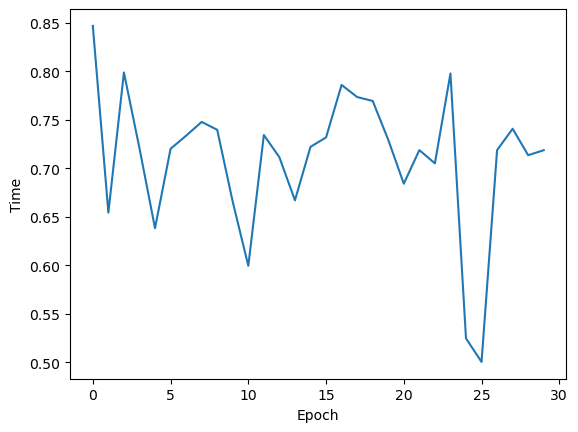

In [32]:
# call training
run_training(model, optimizer, loss_function, train_loader, valid_loader, device, n_epochs=30)


In [33]:
# Creates automatic mixed precision scalar at the beginning of training
scaler = torch.cuda.amp.GradScaler()

In [58]:
# training with amp
def train_with_amp(model, optimizer, loss_function, loader, device):

        model.train()

        # running loss
        running_loss = 0.
        
        # loss history
        running_loss_history = []
        
        start_time = time.time()

        for i, batch in enumerate(loader):
            batch_size = batch[0].shape[0]

            # 1: zero gradients
            optimizer.zero_grad()

            # 2: get model predictions
            pred = model(batch[0].to(device), batch[1])

            # 3: get loss
            loss = loss_function(pred.view(-1, pred.size(2)), batch[2].view(-1).to(device))

            running_loss += (loss.item() - running_loss) / (i + 1)
            running_loss_history.append(running_loss)

            # 4: get gradients
            # Scales the loss, and calls backward()
            # to create scaled gradients
            scaler.scale(loss).backward()
                        
            # 5: clip the grad norm
            nn.utils.clip_grad_norm_(model.parameters(), 3.0)

            # 6: use optimizer to take gradient step
            # Unscales gradients and calls
            # or skips optimizer.step()
            scaler.step(optimizer)
            
            # 7: updates the scale for next iteration
            scaler.update()

        end_time = time.time()
        
        train_time = end_time - start_time
        
        # metrics
        mean_running_loss = np.mean(running_loss_history)

        # to free memory
        del running_loss_history
        
        print("Train Loss: ", mean_running_loss)
        
        train_pp = np.exp(mean_running_loss)

        print("Train Perplexity: ", train_pp)

        return [mean_running_loss], [train_pp], train_time
    
def evaluate(model, optimizer, loss_function, loader, device, min_loss=1000):

    # to run model in evaluation mode, dropouts are ignored in eval mode
    model.eval()

    running_loss = 0.
    running_loss_history = []
    
    start_time = time.time()
    # we don't calculate greadiants in eval time
    with torch.no_grad():
        for i, batch in enumerate(loader):

            # 1: get model predictions
            pred = model(batch[0].to(device), batch[1])
            
            # 2: get loss
            loss = loss_function(pred.view(-1, pred.size(2)), batch[2].view(-1).to(device))

            running_loss += (loss.item() - running_loss) / (i + 1)
            
            running_loss_history.append(running_loss)
            

    end_time = time.time()
    
    eval_time = end_time - start_time
    
    # metrics
    mean_running_loss = np.mean(running_loss_history)

    # to free memory
    del running_loss_history
            
    print("Validation Loss: ",  mean_running_loss)
  
    val_pp = np.exp(mean_running_loss)

    print("Validation Perplexity: ", val_pp)

    return [mean_running_loss], [val_pp], min_loss, eval_time

def run_training_with_amp(model, optimizer, loss_function, train_loader, valid_loader, device, n_epochs=20):
        train_running_losses = []
        train_running_perplexity = []

        validation_running_losses = []
        validation_running_perplexity = []

        #. initialize minimum loss to a high value
        min_loss = 1000
        
        total_training_time = 0.0
        time_list = []

        for i in range(n_epochs):
            print("Epoch: {}".format(i))
            
            # run training
            train_running_loss_history, train_perplexity_history, train_time = train_with_amp(model, optimizer, loss_function, train_loader, device)

            # run validation
            validation_running_loss_history, validation_perplexity_history, new_min_loss, valid_time = evaluate(model, optimizer, loss_function, valid_loader, device, min_loss=min_loss)

            time_diff = train_time + valid_time
            time_list.append(time_diff)
            total_training_time += time_diff
            
            min_loss = new_min_loss
                        
            train_running_losses.append(train_running_loss_history)
            train_running_perplexity.append(train_perplexity_history)
            
            validation_running_losses.append(validation_running_loss_history)
            validation_running_perplexity.append(validation_perplexity_history)

        # cumulative metrics for time

        time_df = pd.DataFrame(columns=["Epoch", "Time"], data={"Epoch": list(range(0, n_epochs)), "Time":  time_list})

        # plot graphs
        sns.lineplot(time_df, x="Epoch" , y="Time")
        
        print("Total training time: {}".format(total_training_time))


In [55]:
# to clear caches and sticky memory
gc.collect()
torch.cuda.empty_cache()

Epoch: 0
Train Loss:  5.137471852489482
Train Perplexity:  170.28471878463054
Validation Loss:  4.09858689043257
Validation Perplexity:  60.25508037740459
Epoch: 1
Train Loss:  5.153732248935764
Train Perplexity:  173.0762500164917
Validation Loss:  4.0259571472803755
Validation Perplexity:  56.03391583277808
Epoch: 2
Train Loss:  5.1289208844206
Train Perplexity:  168.83482741363935
Validation Loss:  4.064043349689907
Validation Perplexity:  58.209196032680616
Epoch: 3
Train Loss:  5.066602950307151
Train Perplexity:  158.6345216360028
Validation Loss:  3.9940818548202515
Validation Perplexity:  54.275984506187726
Epoch: 4
Train Loss:  5.047607418072115
Train Perplexity:  155.64961417284528
Validation Loss:  4.083052357037862
Validation Perplexity:  59.32627874731022
Epoch: 5
Train Loss:  5.046222463543041
Train Perplexity:  155.43419574154677
Validation Loss:  4.19367610083686
Validation Perplexity:  66.26594405132668
Epoch: 6
Train Loss:  5.012845110655299
Train Perplexity:  150.331

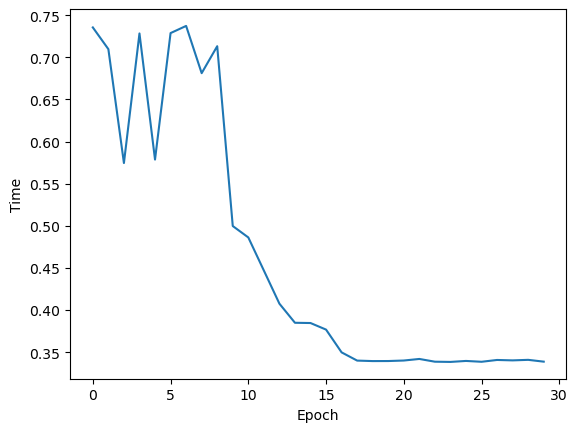

In [ ]:
# call training with amp
run_training_with_amp(model, optimizer, loss_function, train_loader, valid_loader, device, n_epochs=30)


In [ ]:
# training with mixed precision reduces the training time by a factor of ~35%